In [1]:
import torch

In [2]:
# math datasets
math_datasets = 'AddSub AQuA gsm8k MultiArith SingleEq SVAMP'

# 
commonsense_datasets='boolq piqa social_i_qa hellaswag winogrande ARC-Challenge ARC-Easy openbookqa'

# sparse MoA  Router weights & threshold analysis

In [7]:
# math
# datasets_name = math_datasets
# path = '/home2/caojie/outputs/LLaMA3-1_smoe_structure/math_14k/b32_gpu2_bsg8_ep2_wep1_loral0-32_lorar8_loraQ,K,V,O,FFN_DOWN_alpha8_maxth0.5_constWFalse_noisyFalse_palayers0-32_pasize16_promptl0-0_promptl10_swi_x4_blr6e-3_maxseq300_flashatt2False_bf16True_abla_Thre/AddSub_mingen120_router_statsroute_stats.pth'

# commonsense
datasets_name = commonsense_datasets
path = '/home2/caojie/outputs/LLaMA3-1_smoe_structure/commonsense_15k/b32_epoch2_warme1_loralayers0-32_lorar8_loraQ,K,V,O,FFN_DOWN_alpha8_max_threshold0.5_bool_weightsFalse_padapter_layers0-32_padaptersize16_padapterhydraTrue_prompt_layers0-0_prompt_len10_swi_x4_blr6e-3_maxseq200_flashatt2False_bf16True_fixTh/boolq_mingen10_router_statsroute_stats.pth'


In [8]:
sparse_moa_experts = 'LoRAQ LoRAK LoRAV LoRAO LoRADOWN ParallelAdapter'

In [9]:
data = torch.load(path.replace('AddSub', 'MultiArith'))

/tmp/ipykernel_648336/3582213934.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path.replace('AddSub', 'MultiArith'))


In [10]:
data

{0: {'sum_weights': tensor([1484.4766, 1505.8906, 1324.3496, 1389.2129, 1492.2188, 1104.9453],
         device='cuda:0'),
  'sum_threshold': tensor([741.2578], device='cuda:0')},
 1: {'sum_weights': tensor([1456.9551, 1382.4180, 1313.9609, 1270.2754, 1446.2793,  105.9785],
         device='cuda:0'),
  'sum_threshold': tensor([738.2900], device='cuda:0')},
 2: {'sum_weights': tensor([1121.8164, 1404.8203, 1292.1680, 1133.5527, 1310.7422,  123.4121],
         device='cuda:0'),
  'sum_threshold': tensor([746.4678], device='cuda:0')},
 3: {'sum_weights': tensor([1070.5078, 1657.3281,  866.8945, 1127.6035, 1596.9688,   45.5469],
         device='cuda:0'),
  'sum_threshold': tensor([753.8193], device='cuda:0')},
 4: {'sum_weights': tensor([1234.0947, 1239.0781, 1053.7754, 1379.9727, 1383.3301,  157.8350],
         device='cuda:0'),
  'sum_threshold': tensor([731.3569], device='cuda:0')},
 5: {'sum_weights': tensor([ 481.2705, 1246.1895,  670.1426, 1039.7812,  998.3027,   17.2324],
         d

In [11]:
datasets = []
for ds in datasets_name.split():
    if 'boolq' in datasets_name:
        data = torch.load(path.replace('boolq', ds))
    else:
        data = torch.load(path.replace('AddSub', ds))
    layer_weights = []
    layer_threshold = []
    for i in range(32):
        layer = data[i]
        layer_weights.append(layer['sum_weights'])
        layer_threshold.append(layer['sum_threshold'])
    weights = torch.stack(layer_weights) / data['token_num']
    threshold = torch.cat(layer_threshold) / data['token_num']
    print(weights.shape)
    print(threshold.shape)
    datasets.append({
        'weights': weights.cpu().numpy(),
        'thresholds': threshold.cpu().numpy()
    }) 

/tmp/ipykernel_648336/2661923125.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path.replace('boolq', ds))


torch.Size([32, 6])
torch.Size([32])
torch.Size([32, 6])
torch.Size([32])
torch.Size([32, 6])
torch.Size([32])
torch.Size([32, 6])
torch.Size([32])
torch.Size([32, 6])
torch.Size([32])
torch.Size([32, 6])
torch.Size([32])
torch.Size([32, 6])
torch.Size([32])
torch.Size([32, 6])
torch.Size([32])


In [8]:
13270/50

265.4

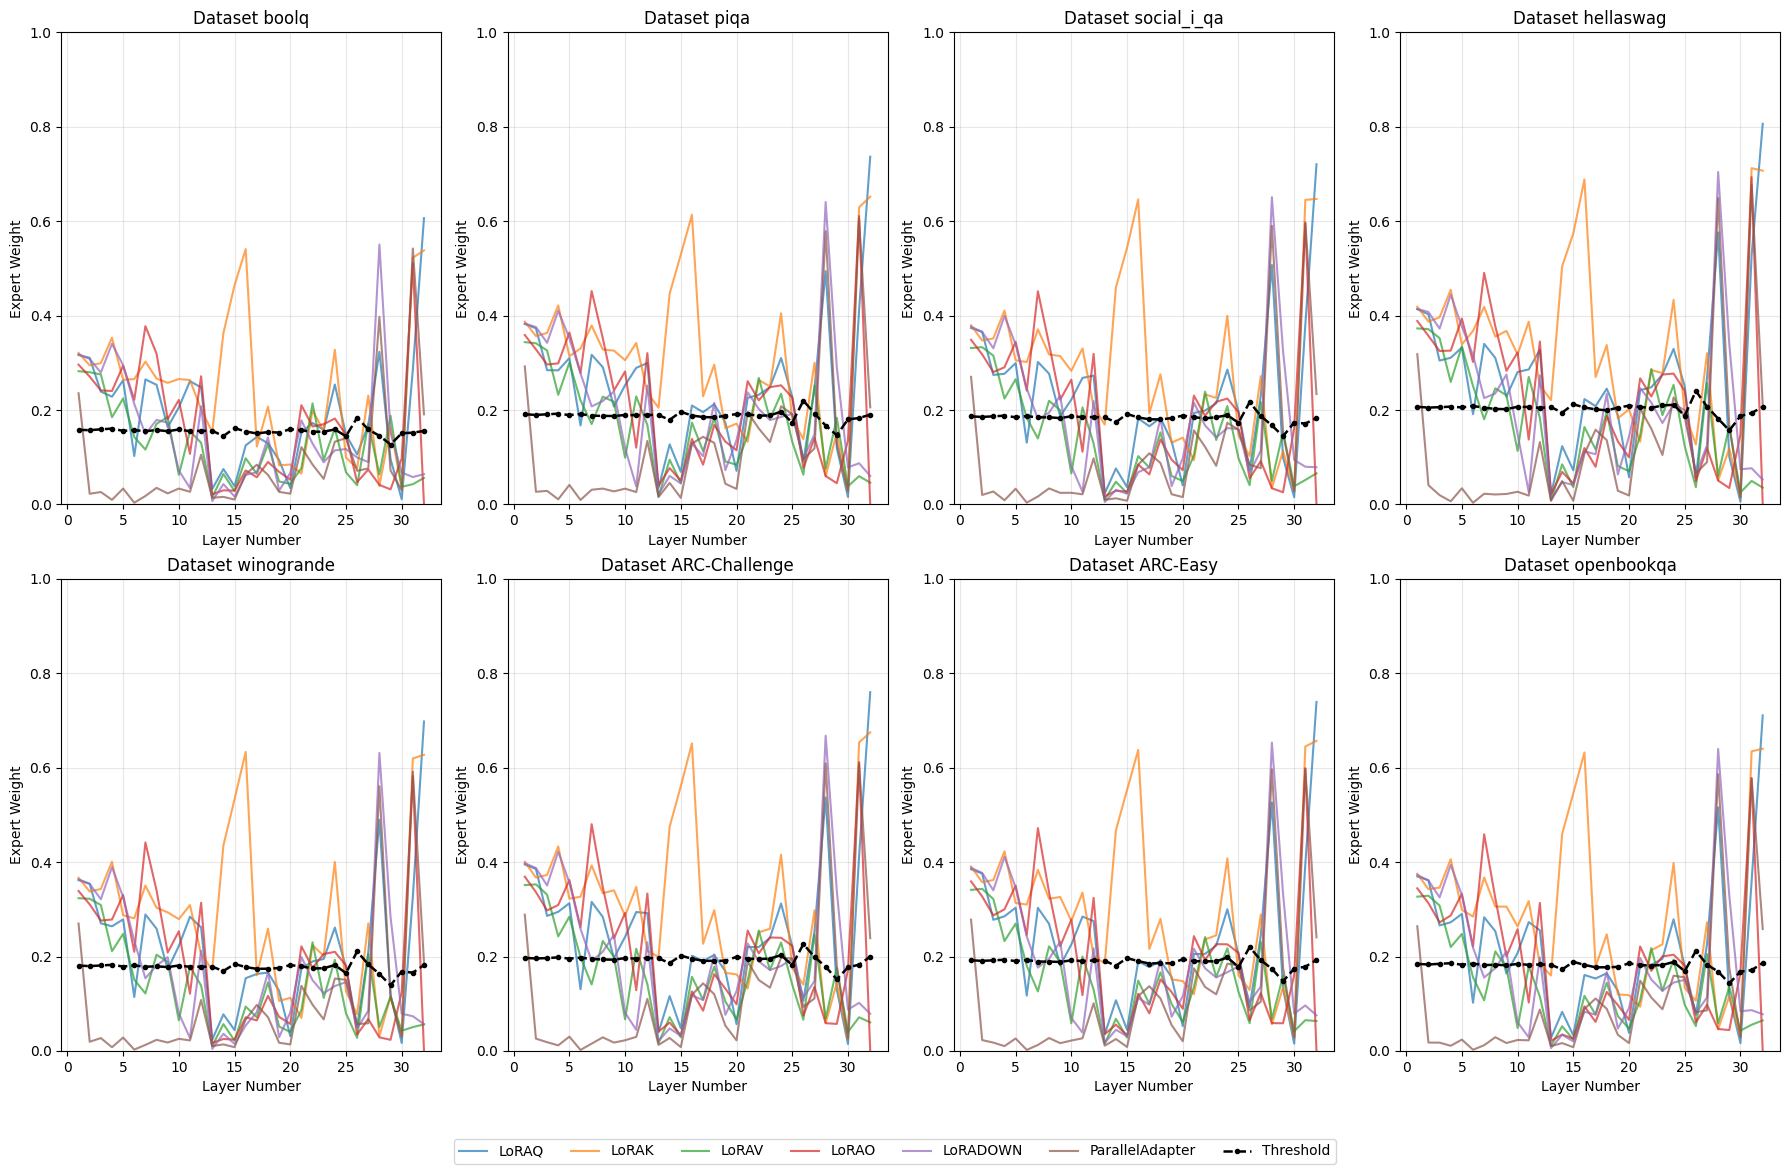

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 模拟数据设置
datasets_name = datasets_name.split()
experts_name = sparse_moa_experts.split()

num_datasets = len(datasets_name)
num_layers = 32
num_experts = len(experts_name)

# 生成模拟数据（带动态阈值）
# np.random.seed(42)
# datasets = []
# for _ in range(num_datasets):
#     # 生成专家权重（32层×7专家）
#     expert_weights = np.random.rand(num_layers, num_experts) * 2 - 0.5
    
#     # 生成动态阈值（每层独立生成）
#     thresholds = np.random.uniform(0.2, 0.8, size=num_layers)
    
#     datasets.append({
#         'weights': expert_weights,
#         'thresholds': thresholds  # 改为复数形式
#     })

# 创建颜色映射
colors = plt.cm.tab10.colors[:num_experts]

# 创建画布和子图
fig, axs = plt.subplots(2, int(num_datasets/2), figsize=(18, 12))
axs = axs.flatten()

# 绘制每个数据集
for idx, (ax, data) in enumerate(zip(axs, datasets)):
    # 绘制专家权重曲线
    for expert in range(num_experts):
        ax.plot(range(1, num_layers+1), 
                data['weights'][:, expert],
                color=colors[expert],
                linewidth=1.5,
                alpha=0.7,
                label=f'{experts_name[expert]}' if idx == 0 else "")
    
    # 绘制动态阈值线
    ax.plot(range(1, num_layers+1), 
           data['thresholds'],
           color='black',
           linestyle='--',
           linewidth=1.8,
           marker='o',
           markersize=3,
           label='Threshold' if idx == 0 else "")
    
    # 设置图表属性
    ax.set_title(f'Dataset {datasets_name[idx]}', fontsize=12)
    ax.set_xlabel('Layer Number', fontsize=10)
    ax.set_ylabel('Expert Weight', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)  # 适当扩大y轴范围

# 添加公共图例
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center', 
           ncol=8,
           fontsize=10,
           bbox_to_anchor=(0.5, 0.02))

# 调整布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

In [13]:
# 对每个数据集求32层均值，
import matplotlib.pyplot as plt
import numpy as np

# 生成带动态阈值的模拟数据
np.random.seed(42)
dataset_stats = []
for ds in datasets:
    
    # 计算各专家的层平均权重
    expert_means = np.mean(ds['weights'], axis=0)
    
    # 计算阈值平均值
    threshold_mean = np.mean(ds['thresholds'])
    
    dataset_stats.append({
        'expert_means': expert_means,
        'threshold_mean': threshold_mean
    })


In [14]:
dataset_stats

[{'expert_means': array([0.18777606, 0.24449365, 0.12230895, 0.16063474, 0.14731543,
         0.08708126], dtype=float32),
  'threshold_mean': np.float32(0.15497625)},
 {'expert_means': array([0.24715215, 0.31037226, 0.16742928, 0.21176395, 0.19984104,
         0.12183557], dtype=float32),
  'threshold_mean': np.float32(0.18727991)},
 {'expert_means': array([0.22516768, 0.29436278, 0.14185163, 0.18987982, 0.18031293,
         0.10577664], dtype=float32),
  'threshold_mean': np.float32(0.18278962)},
 {'expert_means': array([0.26724383, 0.33798307, 0.17354397, 0.22454847, 0.21121456,
         0.12290391], dtype=float32),
  'threshold_mean': np.float32(0.20283797)},
 {'expert_means': array([0.21331668, 0.2800632 , 0.13136096, 0.17891824, 0.16624491,
         0.09595765], dtype=float32),
  'threshold_mean': np.float32(0.1768631)},
 {'expert_means': array([0.24627657, 0.3157163 , 0.16142102, 0.21153216, 0.20026954,
         0.12007796], dtype=float32),
  'threshold_mean': np.float32(0.19337

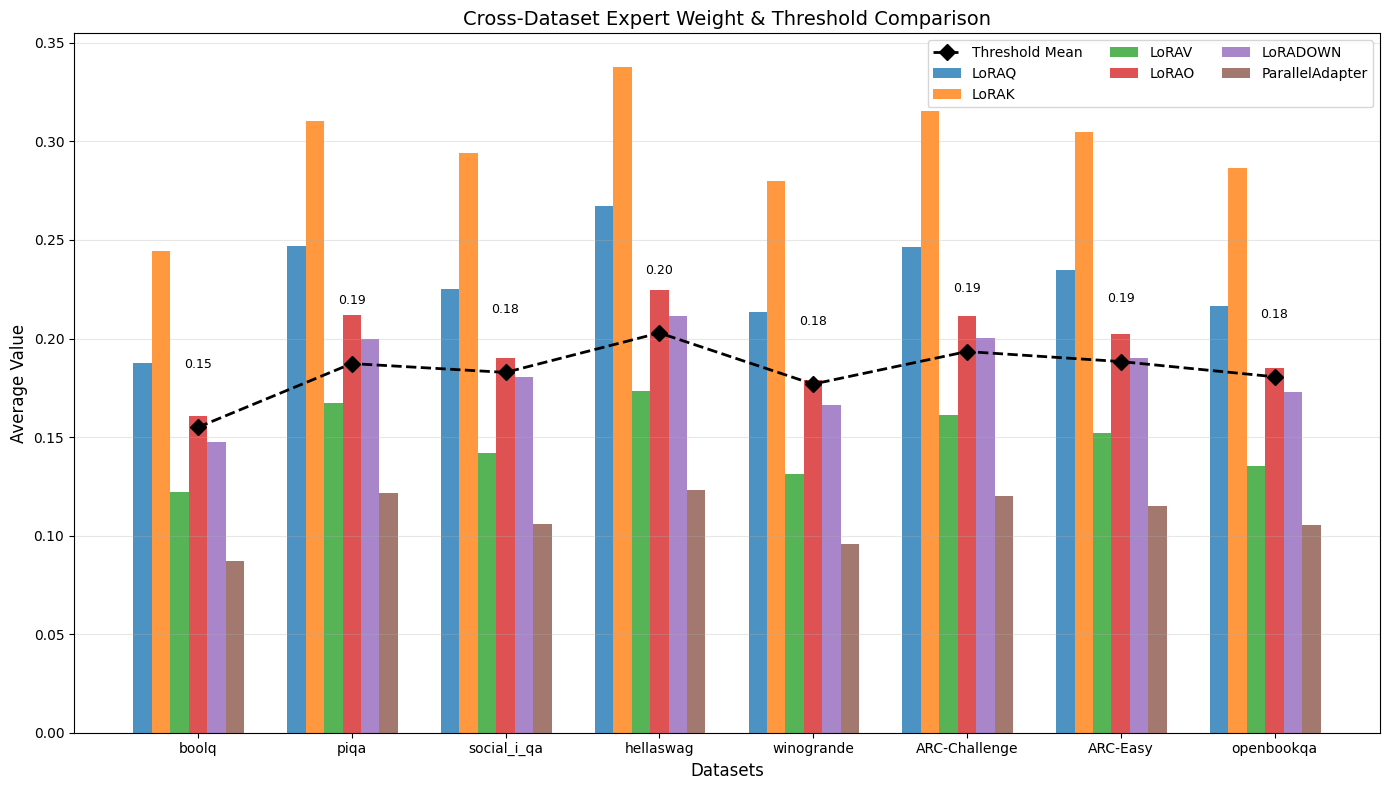

In [15]:

# 可视化设置
colors = plt.cm.tab10.colors[:num_experts]
dataset_labels = datasets_name
x = np.arange(num_datasets)  # 数据集位置
width = 0.12  # 柱状图宽度

# 创建画布
fig, ax = plt.subplots(figsize=(14, 8))

# 绘制每个专家的柱状图
for expert_idx in range(num_experts):
    # 获取所有数据集当前专家的均值
    expert_values = [ds['expert_means'][expert_idx] for ds in dataset_stats]
    
    # 计算柱状图位置偏移
    offset = width * (expert_idx - num_experts//2)
    
    ax.bar(x + offset, 
           expert_values, 
           width=width,
           color=colors[expert_idx],
           alpha=0.8,
           label=f'{experts_name[expert_idx]}')

# 绘制阈值均值折线
threshold_values = [ds['threshold_mean'] for ds in dataset_stats]
ax.plot(x, threshold_values,
        color='black', 
        marker='D',
        linestyle='--',
        linewidth=2,
        markersize=8,
        label='Threshold Mean')

# 图表装饰
ax.set_title('Cross-Dataset Expert Weight & Threshold Comparison', fontsize=14)
ax.set_xlabel('Datasets', fontsize=12)
ax.set_ylabel('Average Value', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(dataset_labels)
ax.grid(True, axis='y', alpha=0.3)
ax.legend(loc='upper right', ncol=3)

# 添加数值标签
for i, thresh in enumerate(threshold_values):
    ax.text(i, thresh+0.03, f'{thresh:.2f}',
            ha='center', 
            color='black',
            fontsize=9)

plt.tight_layout()
plt.show()

# soft MOA  router stats

In [14]:
# math
datasets_name = math_datasets
path = '/home2/caojie/outputs/LLaMA3-1_lora_moe_structure/math_14k/b32_epoch2_warme1_loralayers0-32_lorar8_loraQ,K,V,O,FFN_DOWN_alpha8_expertnum1_hydraTrue_padapter_layers0-32_padaptersize16_padapterhydraTrue_prompt_layers0-32_prompt_len10_swi_x4_blr6e-3_maxseq300_flashatt2False_bf16True_sigmoid1Gpu/AddSub_mingen120_router_statsroute_stats.pth'

# commonsense
datasets_name = commonsense_datasets
path = '/home2/caojie/outputs/LLaMA3-1_lora_moe_structure/commonsense_15k/b32_epoch2_warme1_loralayers0-32_lorar8_loraQ,K,V,O,FFN_DOWN_alpha8_expertnum1_hydraTrue_padapter_layers0-32_padaptersize16_padapterhydraTrue_prompt_layers0-32_prompt_len10_blr6e-3_maxseq200_flashatt2False_bf16True_sigmoid/boolq_mingen10_routerStatsroute_stats.pth'

In [15]:
soft_moa_experts = 'LoRAQ LoRAK LoRAV Prompt LoRAO LoRADOWN ParallelAdapter'

In [16]:
data = torch.load(path.replace('AddSub', 'MultiArith'))

/tmp/ipykernel_937829/3582213934.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path.replace('AddSub', 'MultiArith'))


In [17]:
data

{0: {'sum_weights': tensor([1496.6250, 1494.1465, 1432.7324, 1412.0371, 1380.9375, 1463.0000,
          1148.6660], device='cuda:0')},
 1: {'sum_weights': tensor([1310.6895, 1408.0977, 1069.4121, 1246.9277, 1267.1055, 1353.2344,
           551.3882], device='cuda:0')},
 2: {'sum_weights': tensor([1331.5176, 1182.8965, 1102.5430, 1168.9531,  995.5938, 1292.3105,
           402.0459], device='cuda:0')},
 3: {'sum_weights': tensor([ 978.8936, 1363.6074,  954.9268, 1252.7656, 1165.8784, 1173.4414,
           440.0314], device='cuda:0')},
 4: {'sum_weights': tensor([1158.7051,  955.7139,  732.4751,  803.3682,  771.7134, 1044.6836,
           502.7412], device='cuda:0')},
 5: {'sum_weights': tensor([ 896.3941,  852.6951,  860.6943, 1622.3301, 1022.8271,  891.4336,
           366.8629], device='cuda:0')},
 6: {'sum_weights': tensor([1089.4688, 1157.3984,  693.7803, 1597.0430, 1017.0801,  882.5576,
           326.9599], device='cuda:0')},
 7: {'sum_weights': tensor([ 969.7404, 1136.2784,  927.

In [18]:
datasets = []
for ds in datasets_name.split():
    if 'boolq' in datasets_name:
        data = torch.load(path.replace('boolq', ds))
    else:
        data = torch.load(path.replace('AddSub', ds))
    layer_weights = []
    for i in range(32):
        layer = data[i]
        layer_weights.append(layer['sum_weights'])
    weights = torch.stack(layer_weights) / data['token_num']
    print(weights.shape)
    datasets.append({
        'weights': weights.cpu().numpy(),
    }) 

torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([32, 7])
torch.Size([32, 7])


/tmp/ipykernel_937829/3726072746.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path.replace('boolq', ds))


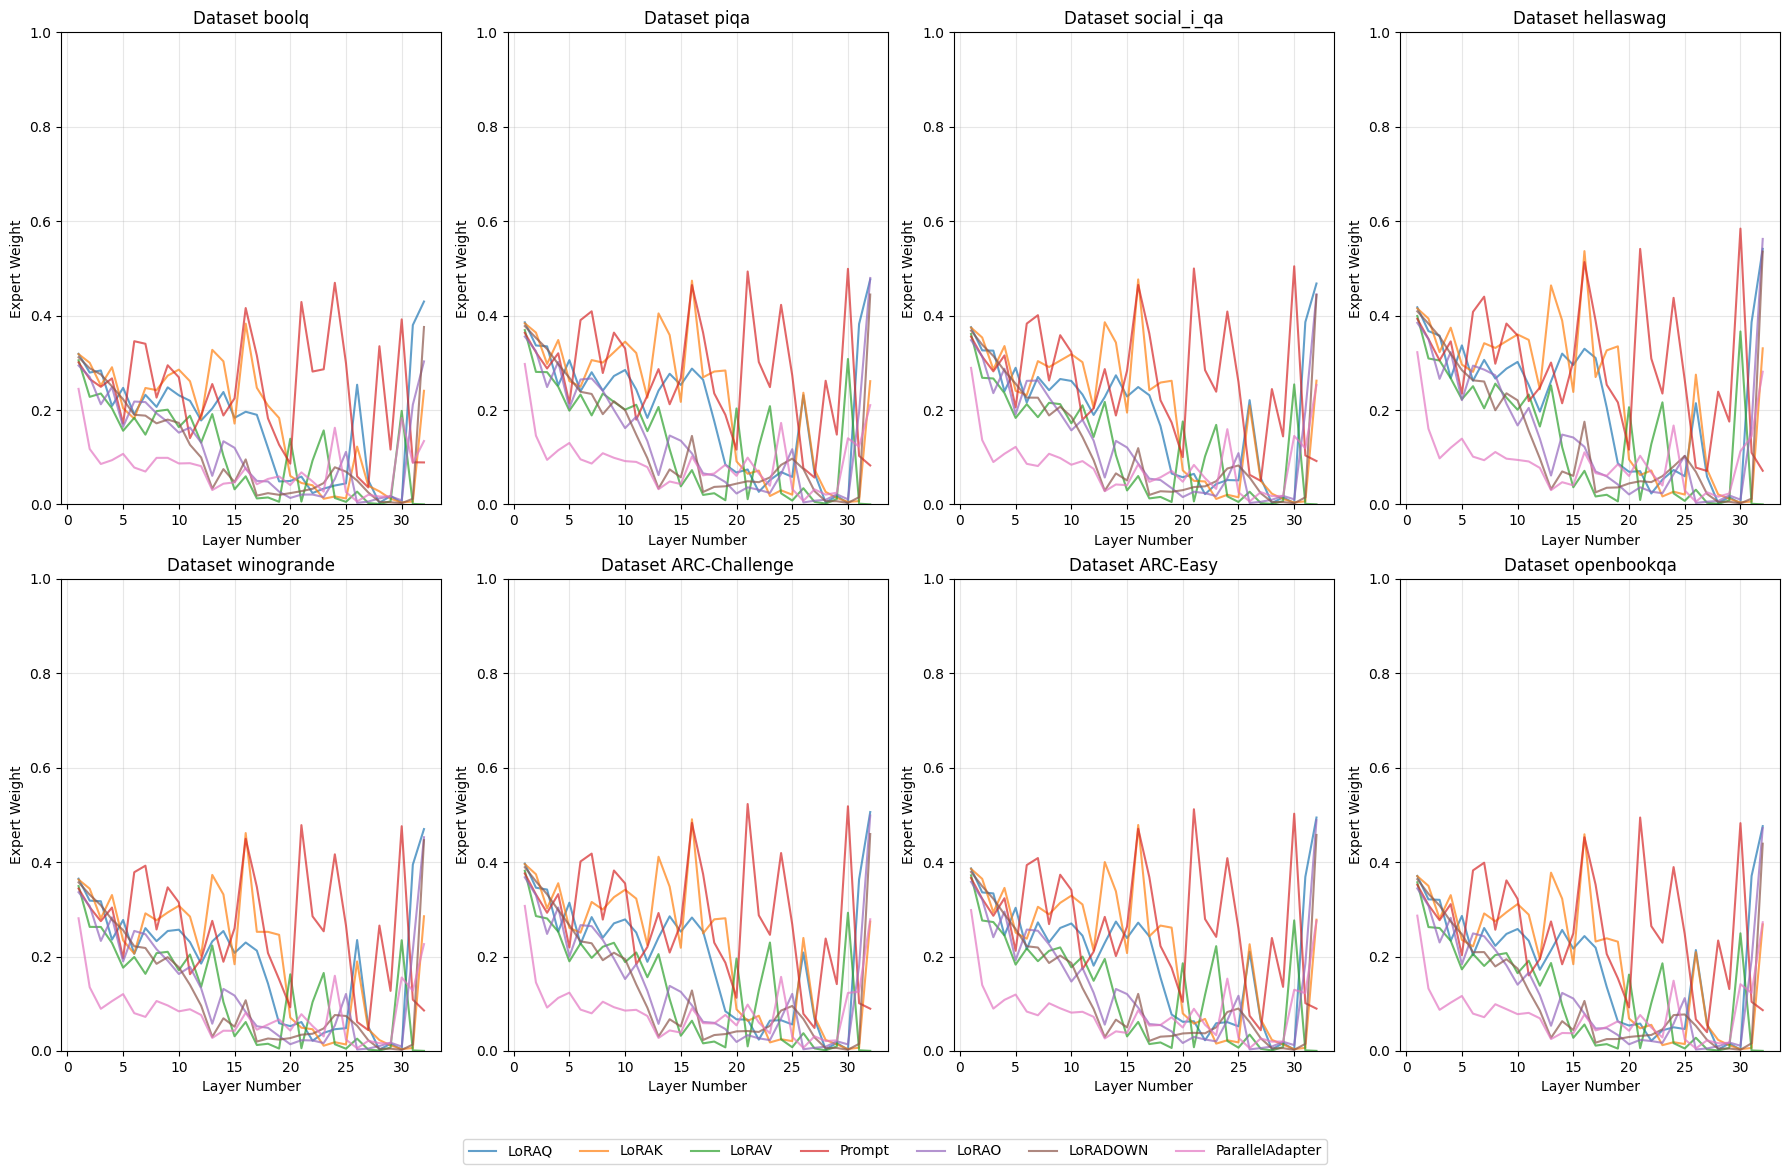

In [19]:
import matplotlib.pyplot as plt
import numpy as np

datasets_name = datasets_name.split()
experts_name = soft_moa_experts.split()

num_datasets = len(datasets_name)
num_layers = 32
num_experts = len(experts_name)

# 创建颜色映射
colors = plt.cm.tab10.colors[:num_experts]

# 创建画布和子图
fig, axs = plt.subplots(2, int(num_datasets/2), figsize=(18, 12))
axs = axs.flatten()

# 绘制每个数据集
for idx, (ax, data) in enumerate(zip(axs, datasets)):
    # 绘制专家权重曲线
    for expert_idx in range(num_experts):
        ax.plot(range(1, num_layers+1), 
                data['weights'][:, expert_idx],
                color=colors[expert_idx],
                linewidth=1.5,
                alpha=0.7,
                label=f'{experts_name[expert_idx]}' if idx == 0 else "")
    
    # 设置图表属性
    ax.set_title(f'Dataset {datasets_name[idx]}', fontsize=12)
    ax.set_xlabel('Layer Number', fontsize=10)
    ax.set_ylabel('Expert Weight', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)  # 适当扩大y轴范围

# 添加公共图例
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center', 
           ncol=8,
           fontsize=10,
           bbox_to_anchor=(0.5, 0.02))

# 调整布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

In [20]:
# 对每个数据集求32层均值，
import matplotlib.pyplot as plt
import numpy as np

dataset_stats = []
for ds in datasets:
    
    # 计算各专家的层平均权重
    expert_means = np.mean(ds['weights'], axis=0)
    
    dataset_stats.append({
        'expert_means': expert_means,
    })

In [21]:
dataset_stats

[{'expert_means': array([0.1691639 , 0.17186849, 0.10654889, 0.24174407, 0.11722514,
         0.11079836, 0.07632808], dtype=float32)},
 {'expert_means': array([0.20220165, 0.21667235, 0.13264635, 0.27479282, 0.14190233,
         0.13512142, 0.09055559], dtype=float32)},
 {'expert_means': array([0.19112608, 0.20283213, 0.12116999, 0.26727116, 0.13336702,
         0.12609   , 0.08536141], dtype=float32)},
 {'expert_means': array([0.21866195, 0.23844892, 0.14264584, 0.29382256, 0.15058711,
         0.14541954, 0.0944345 ], dtype=float32)},
 {'expert_means': array([0.18484858, 0.1964933 , 0.11719168, 0.25967103, 0.13166608,
         0.12306765, 0.08288085], dtype=float32)},
 {'expert_means': array([0.20206654, 0.2177713 , 0.1317628 , 0.27830046, 0.14007685,
         0.13268903, 0.08841871], dtype=float32)},
 {'expert_means': array([0.19517232, 0.20970005, 0.12603423, 0.2704617 , 0.13526475,
         0.12792748, 0.08507214], dtype=float32)},
 {'expert_means': array([0.1840004 , 0.19624454,

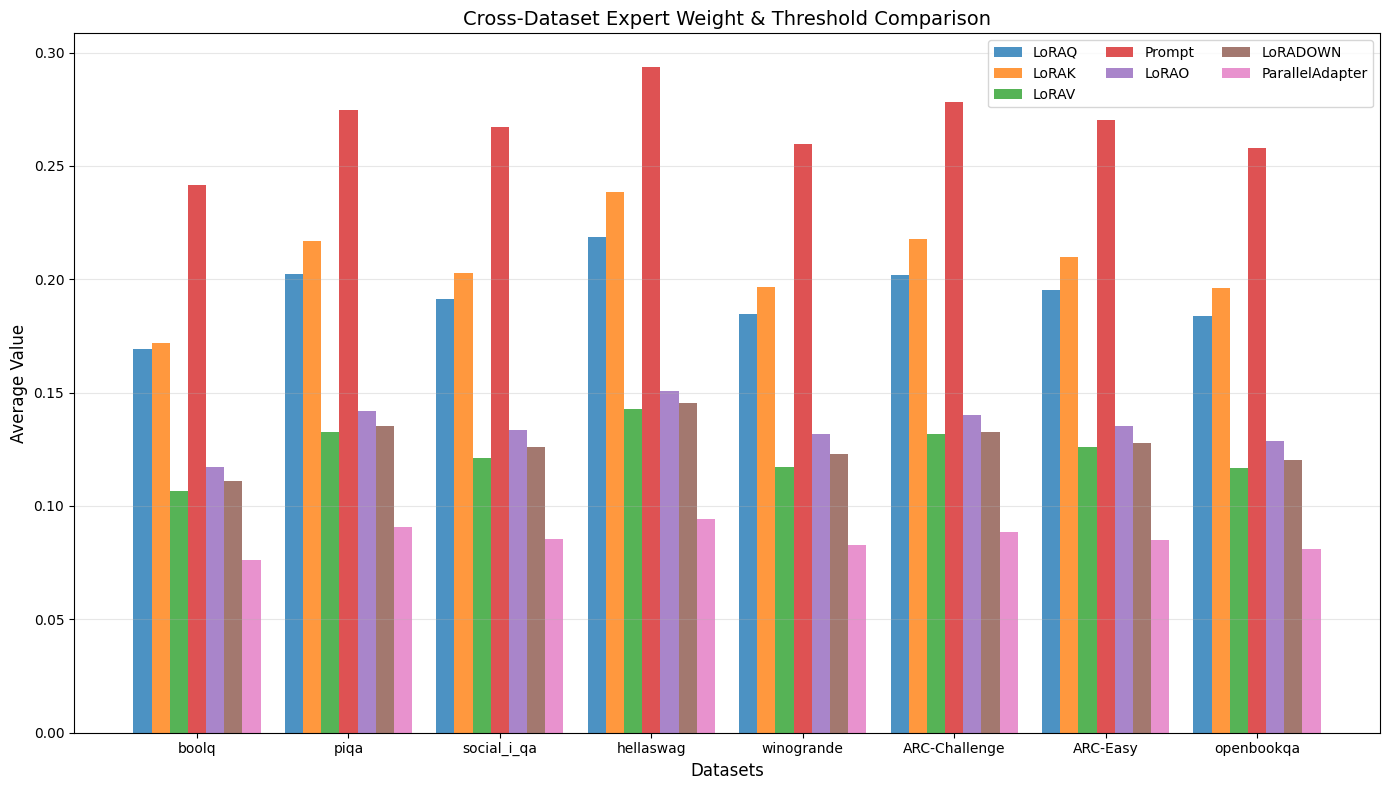

In [22]:

# 可视化设置
colors = plt.cm.tab10.colors[:num_experts]
dataset_labels = datasets_name
x = np.arange(num_datasets)  # 数据集位置
width = 0.12  # 柱状图宽度

# 创建画布
fig, ax = plt.subplots(figsize=(14, 8))

# 绘制每个专家的柱状图
for expert_idx in range(num_experts):
    # 获取所有数据集当前专家的均值
    expert_values = [ds['expert_means'][expert_idx] for ds in dataset_stats]
    
    # 计算柱状图位置偏移
    offset = width * (expert_idx - num_experts//2)
    
    ax.bar(x + offset, 
           expert_values, 
           width=width,
           color=colors[expert_idx],
           alpha=0.8,
           label=f'{experts_name[expert_idx]}')

# 图表装饰
ax.set_title('Cross-Dataset Expert Weight & Threshold Comparison', fontsize=14)
ax.set_xlabel('Datasets', fontsize=12)
ax.set_ylabel('Average Value', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(dataset_labels)
ax.grid(True, axis='y', alpha=0.3)
ax.legend(loc='upper right', ncol=3)


plt.tight_layout()
plt.show()